In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from copy import deepcopy

import numpy as np
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax, value_and_grad

from optimisers import build_optimiser
from util import init_params

# NN overfitting example

**idea:**

1. generate 1D regression data
2. Fit NN
3. fit high dimensional polynomial
4. Fit NN to polynomial
5. Try these fitted params from (4) to the original data. Estimate the 'width' of this mode (Hessian?)


## generate data



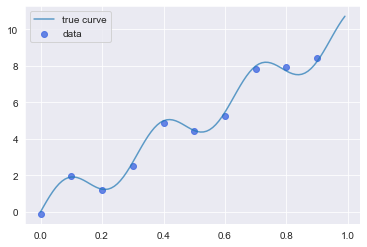

In [4]:
key = random.PRNGKey(0)

x_max = 1

x_range = np.arange(0, x_max, 0.01)
x_data = np.arange(0, x_max, 0.1)
y_data = np.sin(x_data*20) + x_data*10 + 0.3*random.normal(key, shape=x_data.shape)


plt.scatter(x_data, y_data, c='royalblue', alpha=.8, label="data")
plt.plot(x_range, np.sin(x_range*20) + x_range*10, alpha=0.7, label="true curve")
plt.legend()

### 1. Linear regression

$y_i = \alpha x_i + \beta$

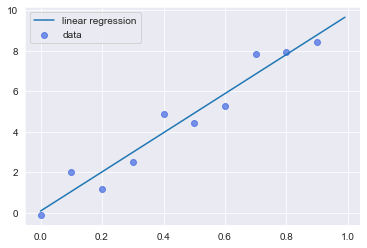

In [5]:
x_centered = x_data - x_data.mean()
y_centered = y_data - y_data.mean()

alpha_hat = np.dot(x_centered, y_centered)/np.sum(np.square(x_centered))
beta_hat = y_data.mean() - alpha_hat*x_data.mean()

prediction_LR = x_range*alpha_hat + beta_hat

def loss_LR(x_data, y_data):
    alpha_hat = np.dot(x_centered, y_centered)/np.sum(np.square(x_centered))
    beta_hat = y_data.mean() - alpha_hat*x_data.mean()
    prediction_LR = x_data*alpha_hat + beta_hat
    return np.mean(np.square(prediction_LR-y_data))

plt.scatter(x_data, y_data, c='royalblue', alpha=.7, label="data")
# plt.plot(x_range, np.sin(x_range) + x_range, alpha=0.5, label="true curve")
plt.plot(x_range, prediction_LR, label="linear regression")
plt.legend()

## Neural network


need to normalise data..


In [6]:
@jit
def predict(params, x):
    activation = x
    for W,b in params[:-1]:
        activation = jnp.tanh(jnp.dot(W, activation) + b)
    
    W_last, b_last = params[-1]
    return jnp.dot(W_last, activation) + b_last

batch_predict = vmap(predict, in_axes=(None, 0))

@jit
def loss_NN(params, x_data, y_data):
    preds = batch_predict(params, x_data)
    return jnp.mean(jnp.square(preds-y_data))

val_and_grad_loss_NN = jit(value_and_grad(loss_NN))


In [12]:
M = 30
D, K, L = 1,1,2
params = init_params(random.PRNGKey(0), M, D, K, L)
x_data_reshaped = deepcopy(x_data).reshape(x_data.shape[0], 1)
y_data_reshaped = deepcopy(y_data).reshape(y_data.shape[0], 1)

# run_sgd = build_optimiser(val_and_grad_loss_NN, "sgd")
run_adam = build_optimiser(val_and_grad_loss_NN, "adam")


LR loss: 0.44
NN loss: 0.00


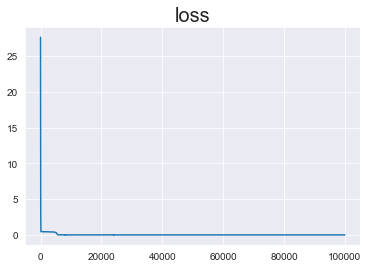

In [13]:
Niters = 100000
learn_rate = 1e-2

opt_params, loss_array = run_adam(Niters, learn_rate, x_data_reshaped, y_data_reshaped, params)

plt.plot(loss_array[:])
plt.title("loss", size=20)

print(f"LR loss: {loss_LR(x_data, y_data):.2f}")
print(f"NN loss: {loss_NN(opt_params, x_data_reshaped, y_data_reshaped):.2f}")

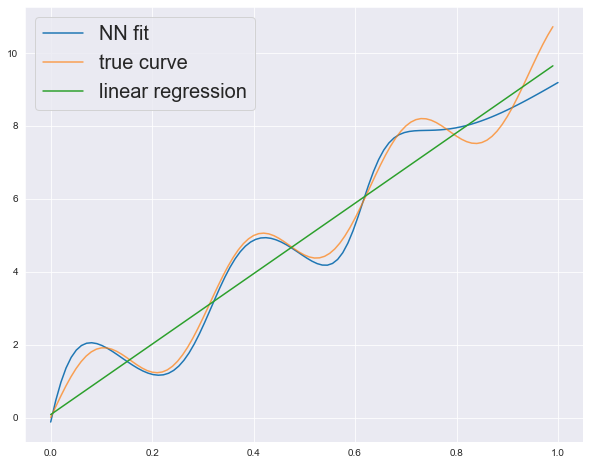

In [14]:
my_preds = batch_predict(opt_params, np.linspace(0,1,100).reshape(100,1))


plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,1,100).reshape(100,1), my_preds, label="NN fit")
plt.plot(x_range, np.sin(x_range*20) + x_range*10, alpha=0.7, label="true curve")
plt.plot(x_range, prediction_LR, label="linear regression")
plt.legend(fontsize=20)

## sin(x) regression data

In [9]:
# print(f"LR loss: {loss_LR(x_data, y_data):.2f}")
# print(f"NN loss: {loss_NN(opt_params, x_data, y_data):.2f}")

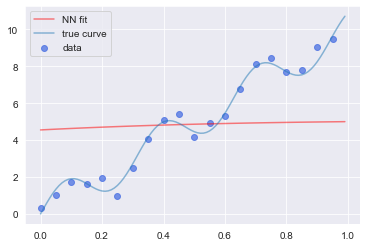

In [133]:
plt.plot(x_range, batch_predict(opt_params, x_range), c='r', alpha=0.5, label="NN fit")

plt.scatter(x_data, y_data, c='royalblue', alpha=.7, label="data")
plt.plot(x_range, np.sin(x_range*20) + x_range*10, alpha=0.5, label="true curve")
# plt.plot(x_range, prediction_LR, label="linear regression")
plt.legend()